## Grupo 7: Rubén Gómez y Adrián Sanjuán

# Índice
- [Carga de datos](#cargadedatos)
- [Modelo](#modelo)
  - [Creación del modelo](#creacion)
  - [Elección de parámetros](#eleccion)
  - [Comparación de mejores modelos](#comp)
  - [Elección de modelo final](#modelofinal)
- [Conclusión](#conclusion)
  - [Posibles mejoras](#mejoras)
- [Bibliografía](#bib)

In [ ]:
import numpy as np
from pandas.io.parsers import read_csv
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.datasets import make_blobs
from scipy import integrate
from sklearn.preprocessing import PolynomialFeatures
from numpy import arange, meshgrid, sqrt
from google.colab import drive
from sklearn.model_selection import train_test_split
drive.mount('/content/drive')
from xgboost import XGBClassifier, plot_tree
from sklearn.model_selection import GridSearchCV
import time
from sklearn.metrics import confusion_matrix
import itertools
import seaborn as sns

Mounted at /content/drive


<a name="cargadedatos"></a>
# Carga de datos

In [ ]:
train = read_csv('/content/drive/MyDrive/AA/PFinal/train.csv', index_col= 0)
test = read_csv('/content/drive/MyDrive/AA/PFinal/test.csv', index_col= 0)
valid = read_csv('/content/drive/MyDrive/AA/PFinal/valid.csv',index_col= 0)

In [ ]:
X_train = train.drop(['is_promoted'], axis=1).values
y_train = train['is_promoted'].values
X_valid = valid.drop(['is_promoted'], axis=1).values
y_valid = valid['is_promoted'].values
X_test = test.drop(['is_promoted'], axis=1).values
y_test = test['is_promoted'].values

<a name="modelo"></a>
# Modelo 
<a name="creacion"></a>
## Creación del modelo

En primer lugar, definimos las siguientes funciones para poder calcular las distintas métricas de interés del modelo.

In [ ]:
epsilon = 0.000000001
def calcular_accuracy(y_true, y_pred):
  true_positives = sum((y_true == 1) & (y_pred == 1))
  true_negatives = sum((y_true == 0) & (y_pred == 0))
  false_positives = sum((y_true == 0) & (y_pred == 1))
  false_negatives = sum((y_true == 1) & (y_pred == 0))
  accuracy = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives + epsilon)
  return accuracy
    
def calcular_precision(y_true, y_pred):
  true_positives = sum((y_true == 1) & (y_pred == 1))
  false_positives = sum((y_true == 0) & (y_pred == 1))
  precision = true_positives / (true_positives + false_positives+ epsilon)
  return precision

def calcular_recall(y_true, y_pred):
  true_positives = sum((y_true == 1) & (y_pred == 1))
  false_negatives = sum((y_true == 1) & (y_pred == 0))
  recall = true_positives / (true_positives + false_negatives+ epsilon)
  return recall

def calcular_false_negatives(y_true, y_pred):
  false_negatives = sum((y_true == 1) & (y_pred == 0))
  return false_negatives

def calcular_f1score(y_true, y_pred):
  precision = calcular_precision(y_true,y_pred)
  recall = calcular_recall(y_true,y_pred)
  return 2*precision*recall/(precision + recall)

<a name="eleccion"></a>
## Elección de parámetros

Exploramos distintos valores de los siguientes parámetros a ajustar en validación.

*  learning_rate: Indica el ratio de aprendizaje en cada paso, utilizado para evitar el overfitting.
*  max_depth: Máxima profundidad de un árbol. Una profundida máxima elevada generará hojas más específicas que se ajusten más a los datos de entrenamiento.
*  n_estimators: Número de árboles construidos por el modelo. Cuántos más árboles se construyan, más se ajustará el modelo a los datos de entrenamiento.
*  subsample: Proporción de submuestras de las instancias de entrenamiento. Si la proporción es alta, el modelo utilizará más instancias para entrenar y se ajustará más a estos datos sobreentrenando. Si la proporción es baja se producirá el efecto contrario.
*  colsample_bytree: Proporción de submuestras de columnas al construir cada árbol. De maner similar a subsample, cuántas menos columnas (variables) utilice para entrenar, más generalizará.
*  min_child_weight: Añade un valor mínimo para que un nodo se ramifique. Para valores altos, se generan modelos más simples que generalizan más.
*  scale_pos_weight: Determina el peso de la clase positiva (en caso binario).

Se han considerado estos parámetros (y sus valores) porque hemos considerado que afectarían más al rendimiento del modelo (over y underfitting) para el problema que se está considerando.




In [ ]:
#Creamos un diccionario para guardar/cargar los modelos ya entrenados
models_dict = dict()
my_array = np.load('/content/drive/MyDrive/AA/PFinal/array_xgb_f1_2.npy', allow_pickle=True)
for key_i in range(len(my_array)):
  if my_array[key_i][0][1] == None:
    tupl = (float(my_array[key_i][0][0]), None, int(my_array[key_i][0][2]), float(my_array[key_i][0][3]), float(my_array[key_i][0][4]), int(my_array[key_i][0][5]) , float(my_array[key_i][0][6]))
  else:
    tupl = (float(my_array[key_i][0][0]), int(my_array[key_i][0][1]), int(my_array[key_i][0][2]), float(my_array[key_i][0][3]), float(my_array[key_i][0][4]), int(my_array[key_i][0][5]) , float(my_array[key_i][0][6]))
  models_dict[tupl]= my_array[key_i][1]

In [ ]:
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [None, 3, 6, 10],
    'n_estimators': [25, 100, 200],
    'subsample': [0.3, 0.6, 0.9],
    'colsample_bytree': [0.5, 0.7, 0.9],
    'min_child_weight': [1, 10, 50],
    'scale_pos_weight' : [10.39],
}

#Ejecutamos grid search sobre param grid
for params in itertools.product(*param_grid.values()):

  lr, max_d, n_est, subs, cols, min_child, weight = params
  
  if params in models_dict:
      continue

  model = XGBClassifier(learning_rate = lr,max_depth = max_d,  n_estimators = n_est, subsample = subs, colsample_bytree = cols, min_child_weight = min_child,
                        scale_pos_weight= weight, random_state = 10)
  model.fit(X_train, y_train)

  # Calculamos métricas sobre entrenamiento y validación
  y_pred = model.predict(X_train)
  val_y_pred = model.predict(X_valid)
  accuracy = calcular_accuracy(y_train,y_pred)
  precision = calcular_precision(y_train,y_pred)
  recall = calcular_recall(y_train,y_pred)
  false_negatives = calcular_false_negatives(y_train,y_pred)
  f1score = calcular_f1score(y_train,y_pred)
  val_accuracy = calcular_accuracy(y_valid,val_y_pred)
  val_precision = calcular_precision(y_valid,val_y_pred)
  val_recall = calcular_recall(y_valid,val_y_pred)
  val_false_negatives = calcular_false_negatives(y_valid,val_y_pred)
  val_f1score = calcular_f1score(y_valid,val_y_pred)


  print(f'Params: {params} \n  accuracy: {accuracy} precision: {precision} recall: {recall} false negatives: {false_negatives} F1Score: {f1score}\
                         \n  val_accuracy: {val_accuracy} val_precision: {val_precision} val_recall: {val_recall} val_false negatives: {val_false_negatives} val_F1Score: {val_f1score}')

  models_dict[params] = [accuracy,precision,recall,false_negatives,f1score,val_accuracy,val_precision,val_recall, val_false_negatives,val_f1score]

Params: (0.1, None, 25, 0.3, 0.5, 1, 10.39) 
  accuracy: 0.8422092856115839 precision: 0.3054334798241499 recall: 0.6258698321733009 false negatives: 914 F1Score: 0.4105249026713893                         
  val_accuracy: 0.8326865028028425 val_precision: 0.2857142857141198 val_recall: 0.6044226044218619 val_false negatives: 322 val_F1Score: 0.38801261829622397
Params: (0.1, None, 25, 0.3, 0.5, 10, 10.39) 
  accuracy: 0.8405562742561147 precision: 0.3017892644134589 recall: 0.6213671715101836 false negatives: 925 F1Score: 0.40626254516247656                         
  val_accuracy: 0.8305304010348393 val_precision: 0.2801624129928769 val_recall: 0.5933660933653644 val_false negatives: 331 val_F1Score: 0.3806146572101019
Params: (0.1, None, 25, 0.3, 0.5, 50, 10.39) 
  accuracy: 0.8278352738248947 precision: 0.2813780260707111 recall: 0.6185018419972909 false negatives: 932 F1Score: 0.38679124536019793                         
  val_accuracy: 0.8201811125484239 val_precision: 0.27043010

El grid search anterior tiene un tiempo de ejecución de poco menos de 2 horas y prueba 324 combinaciones. Tarda unos segundos en experimentar con cada combinación de parámetros tardando más cuando el parámetro n_estimators tiene un valor elevado o el parámetro max_depth es igual a 'None' (ya que puede llegar a generar árboles de profundidad máxima).

In [ ]:
my_array = np.array(list(models_dict.items()))
np.save('/content/drive/MyDrive/AA/PFinal/array_xgb_f1_2.npy', my_array)

<ipython-input-26-3b0a14082948>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  my_array = np.array(list(models_dict.items()))


A continuación mostramos los mejores modelos atendiendo a su métrica F1 score en el conjunto de validación.

In [ ]:
# Visualizar mejores 10 modelos segun val_f1_score
models_rank = sorted(models_dict.items(), key=lambda x: -x[1][9])
print('Best models (val_false_negative):')
print('(metrics = [loss-accuracy-precision-recall-false_negatives-val_loss-val_accuracy-val_precision-val_recall-val_false_negatives,val_f1_score])')
for i in range(10):
  print('----------------')
  print(f'Parameters: {models_rank[i][0]}')
  print(f'  metrics: {models_rank[i][1]}')


Best models (val_false_negative):
(metrics = [loss-accuracy-precision-recall-false_negatives-val_loss-val_accuracy-val_precision-val_recall-val_false_negatives,val_f1_score])
----------------
Parameters: (0.001, 10, 200, 0.3, 0.9, 1, 10.39)
  metrics: [0.9064251832686177, 0.4728499156828085, 0.5738845681536742, 1041, 0.5184911242601632, 0.8960758947821371, 0.4246987951802965, 0.5196560196553812, 391, 0.46740331491661063]
----------------
Parameters: (0.001, 10, 100, 0.3, 0.9, 1, 10.39)
  metrics: [0.9073235590052857, 0.47679180887355743, 0.5718379042158936, 1046, 0.5200074446303667, 0.8963993100473375, 0.42522889114910967, 0.5135135135128827, 396, 0.46521981079525293]
----------------
Parameters: (0.01, 10, 100, 0.3, 0.9, 1, 10.39)
  metrics: [0.9046284317952815, 0.4657800843332904, 0.5878018829305821, 1007, 0.5197249366628592, 0.8927339370417321, 0.4122211445194838, 0.5221130221123808, 389, 0.4607046070455711]
----------------
Parameters: (0.001, 10, 25, 0.3, 0.9, 1, 10.39)
  metrics:

Nos interesa tener un F1 score alto para tener un equilibrio adecuado entre recall y precision, sin embargo también nos interesa mantener un número relativamente bajo de falsos negativos. A continuación experimentamos con distintos valores de estas dos métricas en el conjunto de validación para encontrar un modelo adecuado.

In [ ]:
# Probamos diferentes valores de val_f1_score y val_falsos_negativos hasta encontrar un equilibrio
for key, value in models_rank:
  if value[8] < 385 and value[9] > 0.45:
    print(f'Parameters: {key}')
    print(f'  metrics: {value}')
    print('----------------')

Parameters: (0.01, 10, 200, 0.3, 0.9, 1, 10.39)
  metrics: [0.9040894063532807, 0.46505875077289266, 0.615636512484398, 939, 0.5298573190063308, 0.8884217335057256, 0.39796860572447096, 0.529484029483379, 383, 0.45440168687353255]
----------------


Vamos a visualizar los mejores modelos en cuanto a la minimización de falsos negativos en validación con el propósito de comparar después con otros modelos.

In [ ]:
# Visualizar mejores 10 modelos según falsos negativos
models_rank = sorted(models_dict.items(), key=lambda x: x[1][8])
print('Best models (val_false_negative):')
print('(metrics = [loss-accuracy-precision-recall-false_negatives-val_loss-val_accuracy-val_precision-val_recall-val_false_negatives,val_f1_score])')
for i in range(5):
  print('----------------')
  print(f'Parameters: {models_rank[i][0]}')
  print(f'  metrics: {models_rank[i][1]}')

Best models (val_false_negative):
(metrics = [loss-accuracy-precision-recall-false_negatives-val_loss-val_accuracy-val_precision-val_recall-val_false_negatives,val_f1_score])
----------------
Parameters: (0.001, 10, 25, 0.9, 0.5, 50, 10.39)
  metrics: [0.8354894351013068, 0.3009509602833673, 0.6606631191155707, 829, 0.41352805534193865, 0.8206123329020245, 0.27321237993582004, 0.6289926289918563, 302, 0.3809523809520975]
----------------
Parameters: (0.1, 3, 100, 0.6, 0.5, 10, 10.39)
  metrics: [0.8270447031766268, 0.2836011687362521, 0.6356938190746477, 890, 0.3922212400554635, 0.8152220784820164, 0.26562499999986167, 0.6265356265348568, 304, 0.37307973664932476]
----------------
Parameters: (0.1, 3, 200, 0.3, 0.5, 10, 10.39)
  metrics: [0.826757222940893, 0.285920057616081, 0.6500204666391117, 855, 0.397148930848969, 0.8177015955152201, 0.2683571051239998, 0.6240786240778574, 306, 0.37532323605439577]
----------------
Parameters: (0.1, 3, 200, 0.3, 0.7, 50, 10.39)
  metrics: [0.82549

En cuanto a la regularización, el XGBClassifier no utiliza los coeficientes de regularización a no ser que se especifique en sus parámetros que el booster sea gblinear. En nuestro caso utilizamos el booster por defecto que al cual no le afecta la regularización.

<a name="comp"></a>
## Comparación de mejores modelos

Después de realizar todo lo anterior, entrenamos el modelo en el conjunto de entrenamiento y validación para valorar su rendimiento con el conjunto de test y observar así su comportamiento.

Vamos a comparar los resultados en test de varias combinaciones de parámetros de las anteriores para justificar nuestra elección final.

In [ ]:
hyperparams_1 = (0.01, 10, 200, 0.3, 0.9, 1, 10.39) #modelo con equilibrio entre FN y f1 score
hyperparams_2 = (0.01, 10, 100, 0.3, 0.7, 1, 10.39) #modelo con 5º mejor f1 score (se ha elegido el 5º porque añadía más variabilidad en los parámetros)
hyperparams_3 = (0.001, 10, 25, 0.9, 0.5, 50, 10.39) #modelo con mejor FN

In [ ]:
X_trainval = np.concatenate((X_train, X_valid), axis=0)
y_trainval = np.concatenate((y_train, y_valid), axis=0)

In [ ]:
# Modelo con equilibrio entre FN y f1 score
lr, max_d, n_est, subs, cols, min_child, weight = hyperparams_1

model = XGBClassifier(learning_rate = lr,max_depth = max_d,  n_estimators = n_est, subsample = subs, colsample_bytree = cols, min_child_weight = min_child, scale_pos_weight= weight, random_state = 10)
model.fit(X_trainval, y_trainval)

y_pred = model.predict(X_trainval)
#Evaluacion en el entrenamiento
accuracy = calcular_accuracy(y_trainval,y_pred)
precision = calcular_precision(y_trainval,y_pred)
recall = calcular_recall(y_trainval,y_pred)
false_negatives = calcular_false_negatives(y_trainval,y_pred)
f1score = calcular_f1score(y_trainval,y_pred)
print(f'TRAIN \nAccuracy: {accuracy} \nPrecision: {precision}\nRecall: {recall}\nFalse negatives: {false_negatives}\nF1Score: {f1score}')
y_pred = model.predict(X_test)
y_pred_1 = y_pred
#Evaluacion en el test
accuracy = calcular_accuracy(y_test,y_pred)
precision = calcular_precision(y_test,y_pred)
recall = calcular_recall(y_test,y_pred)
false_negatives = calcular_false_negatives(y_test,y_pred)
f1score = calcular_f1score(y_test,y_pred)
print(f'TEST \nAccuracy: {accuracy} \nPrecision: {precision}\nRecall: {recall}\nFalse negatives: {false_negatives}\nF1Score: {f1score}')

TRAIN 
Accuracy: 0.8971269943941113 
Precision: 0.43838028169004434
Recall: 0.6116057721828027
False negatives: 1265
F1Score: 0.5107037559285961
TEST 
Accuracy: 0.8845407503233199 
Precision: 0.3841298467084002
Recall: 0.5233415233408805
False negatives: 388
F1Score: 0.44305772230843155


In [ ]:
# Modelo con 5º mejor f1 score (se ha elegido el 5º porque añadía más variabilidad en los parámetros)
lr, max_d, n_est, subs, cols, min_child, weight = hyperparams_2

model = XGBClassifier(learning_rate = lr,max_depth = max_d,  n_estimators = n_est, subsample = subs, colsample_bytree = cols, min_child_weight = min_child, scale_pos_weight= weight, random_state = 10)
model.fit(X_trainval, y_trainval)

y_pred = model.predict(X_trainval)
#Evaluacion en el entrenamiento
accuracy = calcular_accuracy(y_trainval,y_pred)
precision = calcular_precision(y_trainval,y_pred)
recall = calcular_recall(y_trainval,y_pred)
false_negatives = calcular_false_negatives(y_trainval,y_pred)
f1score = calcular_f1score(y_trainval,y_pred)
print(f'TRAIN \nAccuracy: {accuracy} \nPrecision: {precision}\nRecall: {recall}\nFalse negatives: {false_negatives}\nF1Score: {f1score}')
y_pred = model.predict(X_test)
y_pred_2 = y_pred
#Evaluacion en el test
accuracy = calcular_accuracy(y_test,y_pred)
precision = calcular_precision(y_test,y_pred)
recall = calcular_recall(y_test,y_pred)
false_negatives = calcular_false_negatives(y_test,y_pred)
f1score = calcular_f1score(y_test,y_pred)
print(f'TEST \nAccuracy: {accuracy} \nPrecision: {precision}\nRecall: {recall}\nFalse negatives: {false_negatives}\nF1Score: {f1score}')

TRAIN 
Accuracy: 0.8899579560155 
Precision: 0.41356215989945294
Recall: 0.6066932760206918
False negatives: 1281
F1Score: 0.49184816428114697
TEST 
Accuracy: 0.8803363518757136 
Precision: 0.37499999999968325
Recall: 0.5454545454538754
False negatives: 370
F1Score: 0.44444444444399955


In [ ]:
# Modelo con mejor FN
lr, max_d, n_est, subs, cols, min_child, weight = hyperparams_3

model = XGBClassifier(learning_rate = lr,max_depth = max_d,  n_estimators = n_est, subsample = subs, colsample_bytree = cols, min_child_weight = min_child, scale_pos_weight= weight, random_state = 10)
model.fit(X_trainval, y_trainval)

y_pred = model.predict(X_trainval)
#Evaluacion en el entrenamiento
accuracy = calcular_accuracy(y_trainval,y_pred)
precision = calcular_precision(y_trainval,y_pred)
recall = calcular_recall(y_trainval,y_pred)
false_negatives = calcular_false_negatives(y_trainval,y_pred)
f1score = calcular_f1score(y_trainval,y_pred)
print(f'TRAIN \nAccuracy: {accuracy} \nPrecision: {precision}\nRecall: {recall}\nFalse negatives: {false_negatives}\nF1Score: {f1score}')
y_pred = model.predict(X_test)
y_pred_3 = y_pred
#Evaluacion en el test
accuracy = calcular_accuracy(y_test,y_pred)
precision = calcular_precision(y_test,y_pred)
recall = calcular_recall(y_test,y_pred)
false_negatives = calcular_false_negatives(y_test,y_pred)
f1score = calcular_f1score(y_test,y_pred)
print(f'TEST \nAccuracy: {accuracy} \nPrecision: {precision}\nRecall: {recall}\nFalse negatives: {false_negatives}\nF1Score: {f1score}')

TRAIN 
Accuracy: 0.8353277274687141 
Precision: 0.2971704820133233
Recall: 0.6416948111757318
False negatives: 1167
F1Score: 0.4062196307093477
TEST 
Accuracy: 0.8302069857696388 
Precision: 0.28069164265113505
Recall: 0.5982800982793633
False negatives: 327
F1Score: 0.3821106316199434


Como podemos ver, las métricas en las que destacaban los modelos se trasladan también al conjunto de test:
- hyperparams_1 = (0.01, 10, 200, 0.3, 0.9, 1, 10.39)
  - Muestra un buen equilibrio entre falsos negativos y f1 score, teniendo la precisión más elevada.
- hyperparams_2 = (0.01, 10, 100, 0.3, 0.7, 1, 10.39)
  - En este caso tenemos el mejor equilibrio entre f1 score y falsos negativos ya que minimiza amba métricas. Es ligeramente peor que el modelo anterior en cuanto a precisión porque ha sacrificado el aumentar los falsos positivos. Esta última cuestión es prácticamente insignificante comparada con las otras dos métricas en las que es mejor. Por la elección de parámetros, se podría decir que este modelo generaliza más que el anterior ya que toma menos columnas para construir los árboles y genera menos estimadores.
- hyperparams_3 = (0.001, 10, 25, 0.9, 0.5, 50, 10.39)
  - El mejor modelo a la hora de reducir los falsos negativos en test pero el peor en f1 score. En este caso es debido a que el modelo identifica más casos positivos de los que debería mejorando los falsos negativos, pero aumentando los falsos positivos a su costa, lo que reduce la precisión y por tanto el f1 score.

A continuación mostramos la matriz de confusión en test para los tres modelos:

In [ ]:
def plot_confusion_matrix(ax, y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False, annot_kws={'fontsize' : 10 }, linewidths=1, linecolor='white', ax = ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    #plt.show()
  

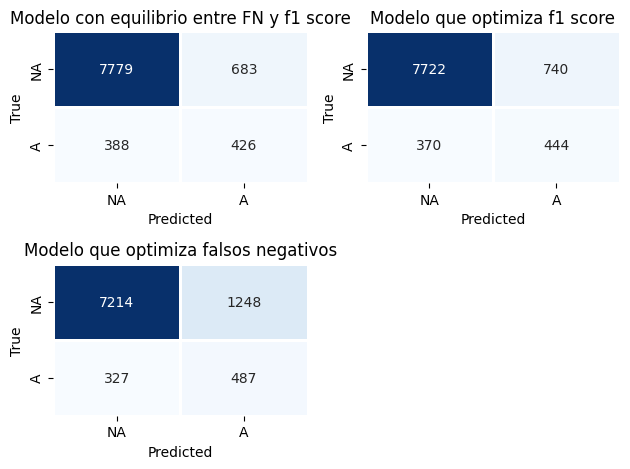

In [ ]:
fig, axes = plt.subplots(2, 2)
axes = axes.flatten()
plot_confusion_matrix(axes[0], y_test, y_pred_1, ['NA', 'A'])
axes[0].set_title('Modelo con equilibrio entre FN y f1 score')
plot_confusion_matrix(axes[1], y_test, y_pred_2, ['NA', 'A'])
axes[1].set_title('Modelo que optimiza f1 score')
plot_confusion_matrix(axes[2], y_test, y_pred_3, ['NA', 'A'])
axes[2].set_title('Modelo que optimiza falsos negativos')
axes[-1].axis('off')
plt.tight_layout()
plt.show()

NA = No ascendidos (0) / A = Ascendidos (1)


En el primero se aprecia un claro equilibrio entre reducir los falsos negativos (predicted = NA y True = A), aunque sea el pero modelo en este aspecto, sin sacrificar tanto como el tercer modelo los falsos positivos (predicted = A y True = NA). El segundo modelo reduce los falsos negativos a costa de incrementar los falsos positivos, a pesar de ello es el que mejor F1 score tiene ya que tiene mejor rendimiento verdaderos positivos (predicted = A y True = A). En el tercer modelo se puede apreciar el efecto comentado anteriormente, reduce falsos negativos a costa de aumentar en gran medida los falsos positivos resultando en el peor de los tres. 

<a name="modelofinal"></a>
## Elección de modelo final

  
Después de el análisis anterior hemos decidido optar por la segunda combinación de parámetros como modelo XGBClassifier final.

In [ ]:
lr, max_d, n_est, subs, cols, min_child, weight = hyperparams_2

model = XGBClassifier(learning_rate = lr,max_depth = max_d,  n_estimators = n_est, subsample = subs, colsample_bytree = cols, min_child_weight = min_child, scale_pos_weight= weight, random_state = 10)
tic = time.time()
model.fit(X_trainval, y_trainval)
toc = time.time()
t = toc - tic

y_pred_1 = model.predict(X_test)

print("Best Hyperparameters:", hyperparams_2, ('learning_rate', 'max_depth', 'n_estimators', 'subsample', 'colsample_bytree', 'min_child_weight', 'scale_pos_weight'))
print(f'Tiempo de ejecución del entrenamiento {t}')
accuracy = calcular_accuracy(y_test,y_pred_1)
precision = calcular_precision(y_test,y_pred_1)
recall = calcular_recall(y_test,y_pred_1)
false_negatives = calcular_false_negatives(y_test,y_pred_1)
f1score = calcular_f1score(y_test,y_pred_1)
print(f'TEST METRICS \nAccuracy: {accuracy} \nPrecision: {precision}\nRecall: {recall}\nFalse negatives: {false_negatives}\nF1Score: {f1score}')

Best Hyperparameters: (0.01, 10, 100, 0.3, 0.7, 1, 10.39) ('learning_rate', 'max_depth', 'n_estimators', 'subsample', 'colsample_bytree', 'min_child_weight', 'scale_pos_weight')
Tiempo de ejecución del entrenamiento 8.884341716766357
TEST METRICS 
Accuracy: 0.8803363518757136 
Precision: 0.37499999999968325
Recall: 0.5454545454538754
False negatives: 370
F1Score: 0.44444444444399955


Aunque ya hayamos entrenado el modelo y lo hayamos evaluado en test, vamos a visualizar como sería la curva de aprendizaje de los parámetros finales sobre entrenamiento con validación.

In [ ]:
lr, max_d, n_est, subs, cols, min_child, weight = hyperparams_1
tam_train = [10, 50, 100, 200, 300, 500,700, 1000, 1500, 3000, 5000, 10000, 15000] 
f1score_list = []
val_f1score_list = []
for tam in tam_train:
  print(tam)
  model = XGBClassifier(learning_rate = lr,max_depth = max_d,  n_estimators = n_est, subsample = subs, colsample_bytree = cols, min_child_weight = min_child, scale_pos_weight= weight, random_state = 10)
  model.fit(X_train[:tam], y_train[:tam])
  y_pred = model.predict(X_train[:tam])
  val_y_pred = model.predict(X_valid)
  f1score = calcular_f1score(y_train[:tam],y_pred)
  val_f1score = calcular_f1score(y_valid,val_y_pred)
  f1score_list.append(f1score)
  val_f1score_list.append(val_f1score)

10
50
100
200
300
500
700
1000
1500
3000
5000
10000
15000


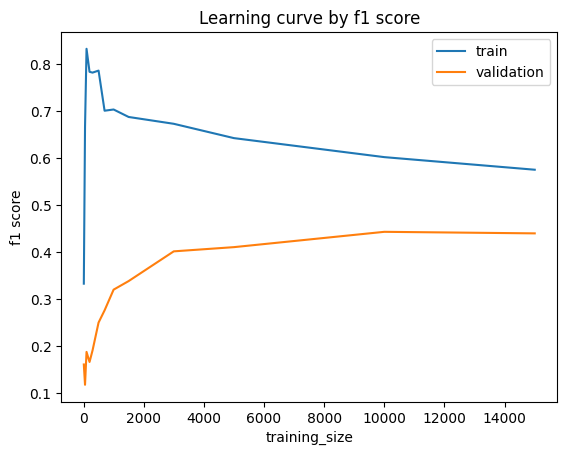

In [ ]:
plt.plot(tam_train,f1score_list)
plt.plot(tam_train,val_f1score_list)
plt.title('Learning curve by f1 score')
plt.ylabel('f1 score')
plt.xlabel('training_size')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

La curva de aprendizaje para el F1 score tiene un aspecto usual, salvo porque al ser de una función que intentamos maximizar el train está encima de la validación. Con pocos datos de entrenamiento, el modelo predice bien esas pocas instancias pero predice mal el conjunto de validación (aunque para muy pocos datos de entrenamieto muestra un F1 score relativamente bajo). Para mayor tamaño del conjunto de entrenamiento el modelo tiene más datos y es capaz de generalizar más, por lo que se observa como sube la validación y baja la de entrenamiento. Se puede observar que ninguna de las gráficas se estabiliza realmente ya que la de entrenamiento sigue una tendencia descendente y la de validación ascendente.

<a name="conclusion"></a>
# Conclusión

El modelo XGBClassifier final elegido funciona mejor que la regresión pero no claramente con respecto a la red neuronal. Hemos conseguido reducir el número de false negatives a 370 prediciendo bien 55% (recall) de los casos ascendidos. Esto lo hace a costa de predecir como ascendidos al 8.7% de los que no deberían ser ascendidos. En total recomienda para ascenso un total de 1180 empleados, siendo correctas el 37% (precision) de las recomendaciones, es decir, ligeramente por encima de una de cada tres recomendaciones.

Es una mejor aproximación que la regresión aunque eso no hace de él un modelo especialmente útil. Es verdad que funciona mejor en algunos aspectos que la red neuronal, recupera más ascendidos que la red neuronal, pero lo hace a costa de recomendar muchos que no son merecedores. En este sentido creemos que la red neuronal ofrece un balance mejor entre estas dos métricas.



<a name="mejoras"></a>
## Posibles mejoras

Pensamos que ninguno de los modelos entrenados ofrece un rendimiento mejor al del humano por lo que ninguno resultaría fiable para una problemática similar.

Algunas alternativas que se podrían probar para mejorar el rendimiento sería probar otras técnicas de clasificación, hacer un preprocesamiento más profesional (haciendo una reducción de dimensionalidad más exhaustiva o realizando extracción de características) o intentar conseguir nuevas variables que puedan estar más correlacionadas. También hemos observado que cada modelo tiene puntos fuertes distintos, por lo que una buena práctica podría ser intentar combinar los 3 de alguna manera para experimentar si mejoran las máetricas de interés.

<a name="bib"></a>
# Bibliografía

- Apuntes de árboles de decisión: https://cvmdp.ucm.es/moodle/mod/resource/view.php?id=2416817
- Documentación XGBClassifier: https://xgboost.readthedocs.io/en/stable/parameter.html
- Práctica de XGBClassifier: https://cvmdp.ucm.es/moodle/mod/resource/view.php?id=2436467